Importation des modules nécéssaires 

In [135]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import accuracy_score


Importation des bases de données (datagouv.fr)

In [136]:
carac = pd.read_csv("Base d'apprentissage/carac.csv",sep=';',low_memory=False)
lieux = pd.read_csv("Base d'apprentissage/lieux.csv",sep=';',low_memory=False)
vict = pd.read_csv("Base d'apprentissage/vict.csv",sep=';',low_memory=False)
veh = pd.read_csv("Base d'apprentissage/veh.csv",sep=';',low_memory=False)

In [137]:
data = vict.merge(veh,on=['Num_Acc','num_veh'])
accident = carac.merge(lieux,on = 'Num_Acc')
data = data.merge(accident,on='Num_Acc')

In [138]:
len(data.index)

127951

Cleaning Data

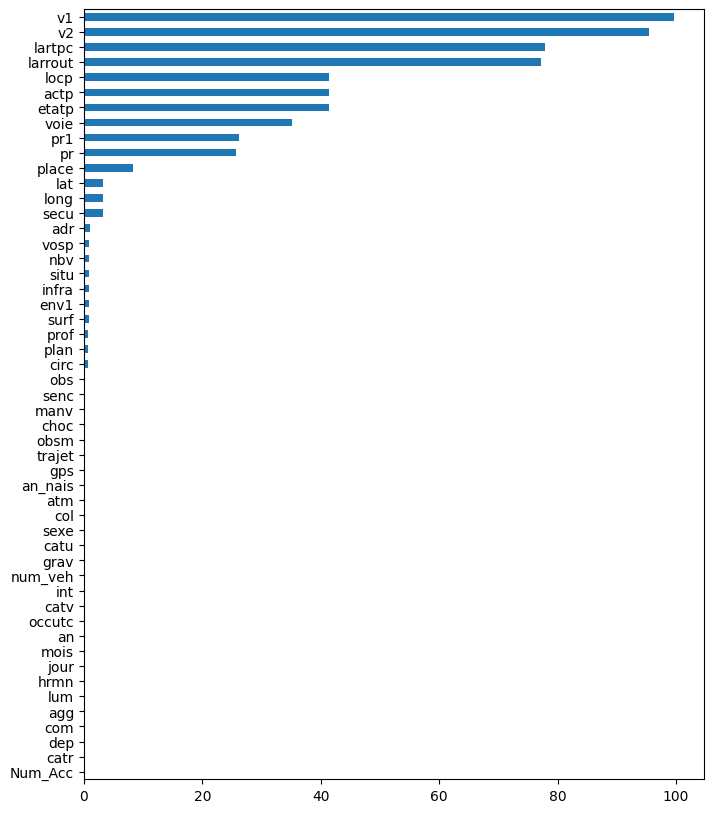

In [139]:
x=data.isna().sum()
x=x.sort_values(ascending=True)*(100/127951)

xtoplot = x.plot(kind='barh', figsize=(8, 10))

Remove columns with too much Nan values

In [140]:
to_remove=["v1","v2",'lartpc','larrout','locp','etatp','actp','voie','pr1','pr','place']
data = data.drop(columns = to_remove)

In [141]:
data.head()

,Num_Acc,catu,grav,sexe,trajet,secu,an_nais,num_veh,senc,catv,...,catr,circ,nbv,vosp,prof,plan,surf,infra,situ,env1
0,201800000001,1,3,1,0.0,11.0,1928.0,B01,0.0,7,...,3,2.0,2.0,0.0,1.0,3.0,1.0,0.0,1.0,0.0
1,201800000001,1,1,1,5.0,11.0,1960.0,A01,0.0,7,...,3,2.0,2.0,0.0,1.0,3.0,1.0,0.0,1.0,0.0
2,201800000002,1,1,1,0.0,11.0,1947.0,A01,0.0,7,...,4,2.0,2.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0
3,201800000002,3,4,1,0.0,2.0,1959.0,A01,0.0,7,...,4,2.0,2.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0
4,201800000003,1,3,1,5.0,21.0,1987.0,A01,0.0,33,...,3,2.0,2.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0


In [142]:
data = data.dropna()

In [143]:
hrmn = pd.cut(data['hrmn'],24,labels=[str(i) for i in range(0,24)])

In [144]:
data['hrmn']=hrmn.values

GPS features

In [145]:
X_lat = data['lat']
X_long = data['long']

X_cluster = np.array((list(zip(X_lat, X_long))))

clustering = KMeans(n_clusters=15, random_state=0)

clustering.fit(X_cluster)

geo = pd.Series(clustering.labels_)
data['geo']=geo

C:\Users\gwendalm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [146]:
new_reference_column = 'grav'

# Reorder the columns with the new reference column first
columns_ordered = [new_reference_column] + [col for col in data.columns if col != new_reference_column]
data_reordered = data[columns_ordered]



Correlation Matrix

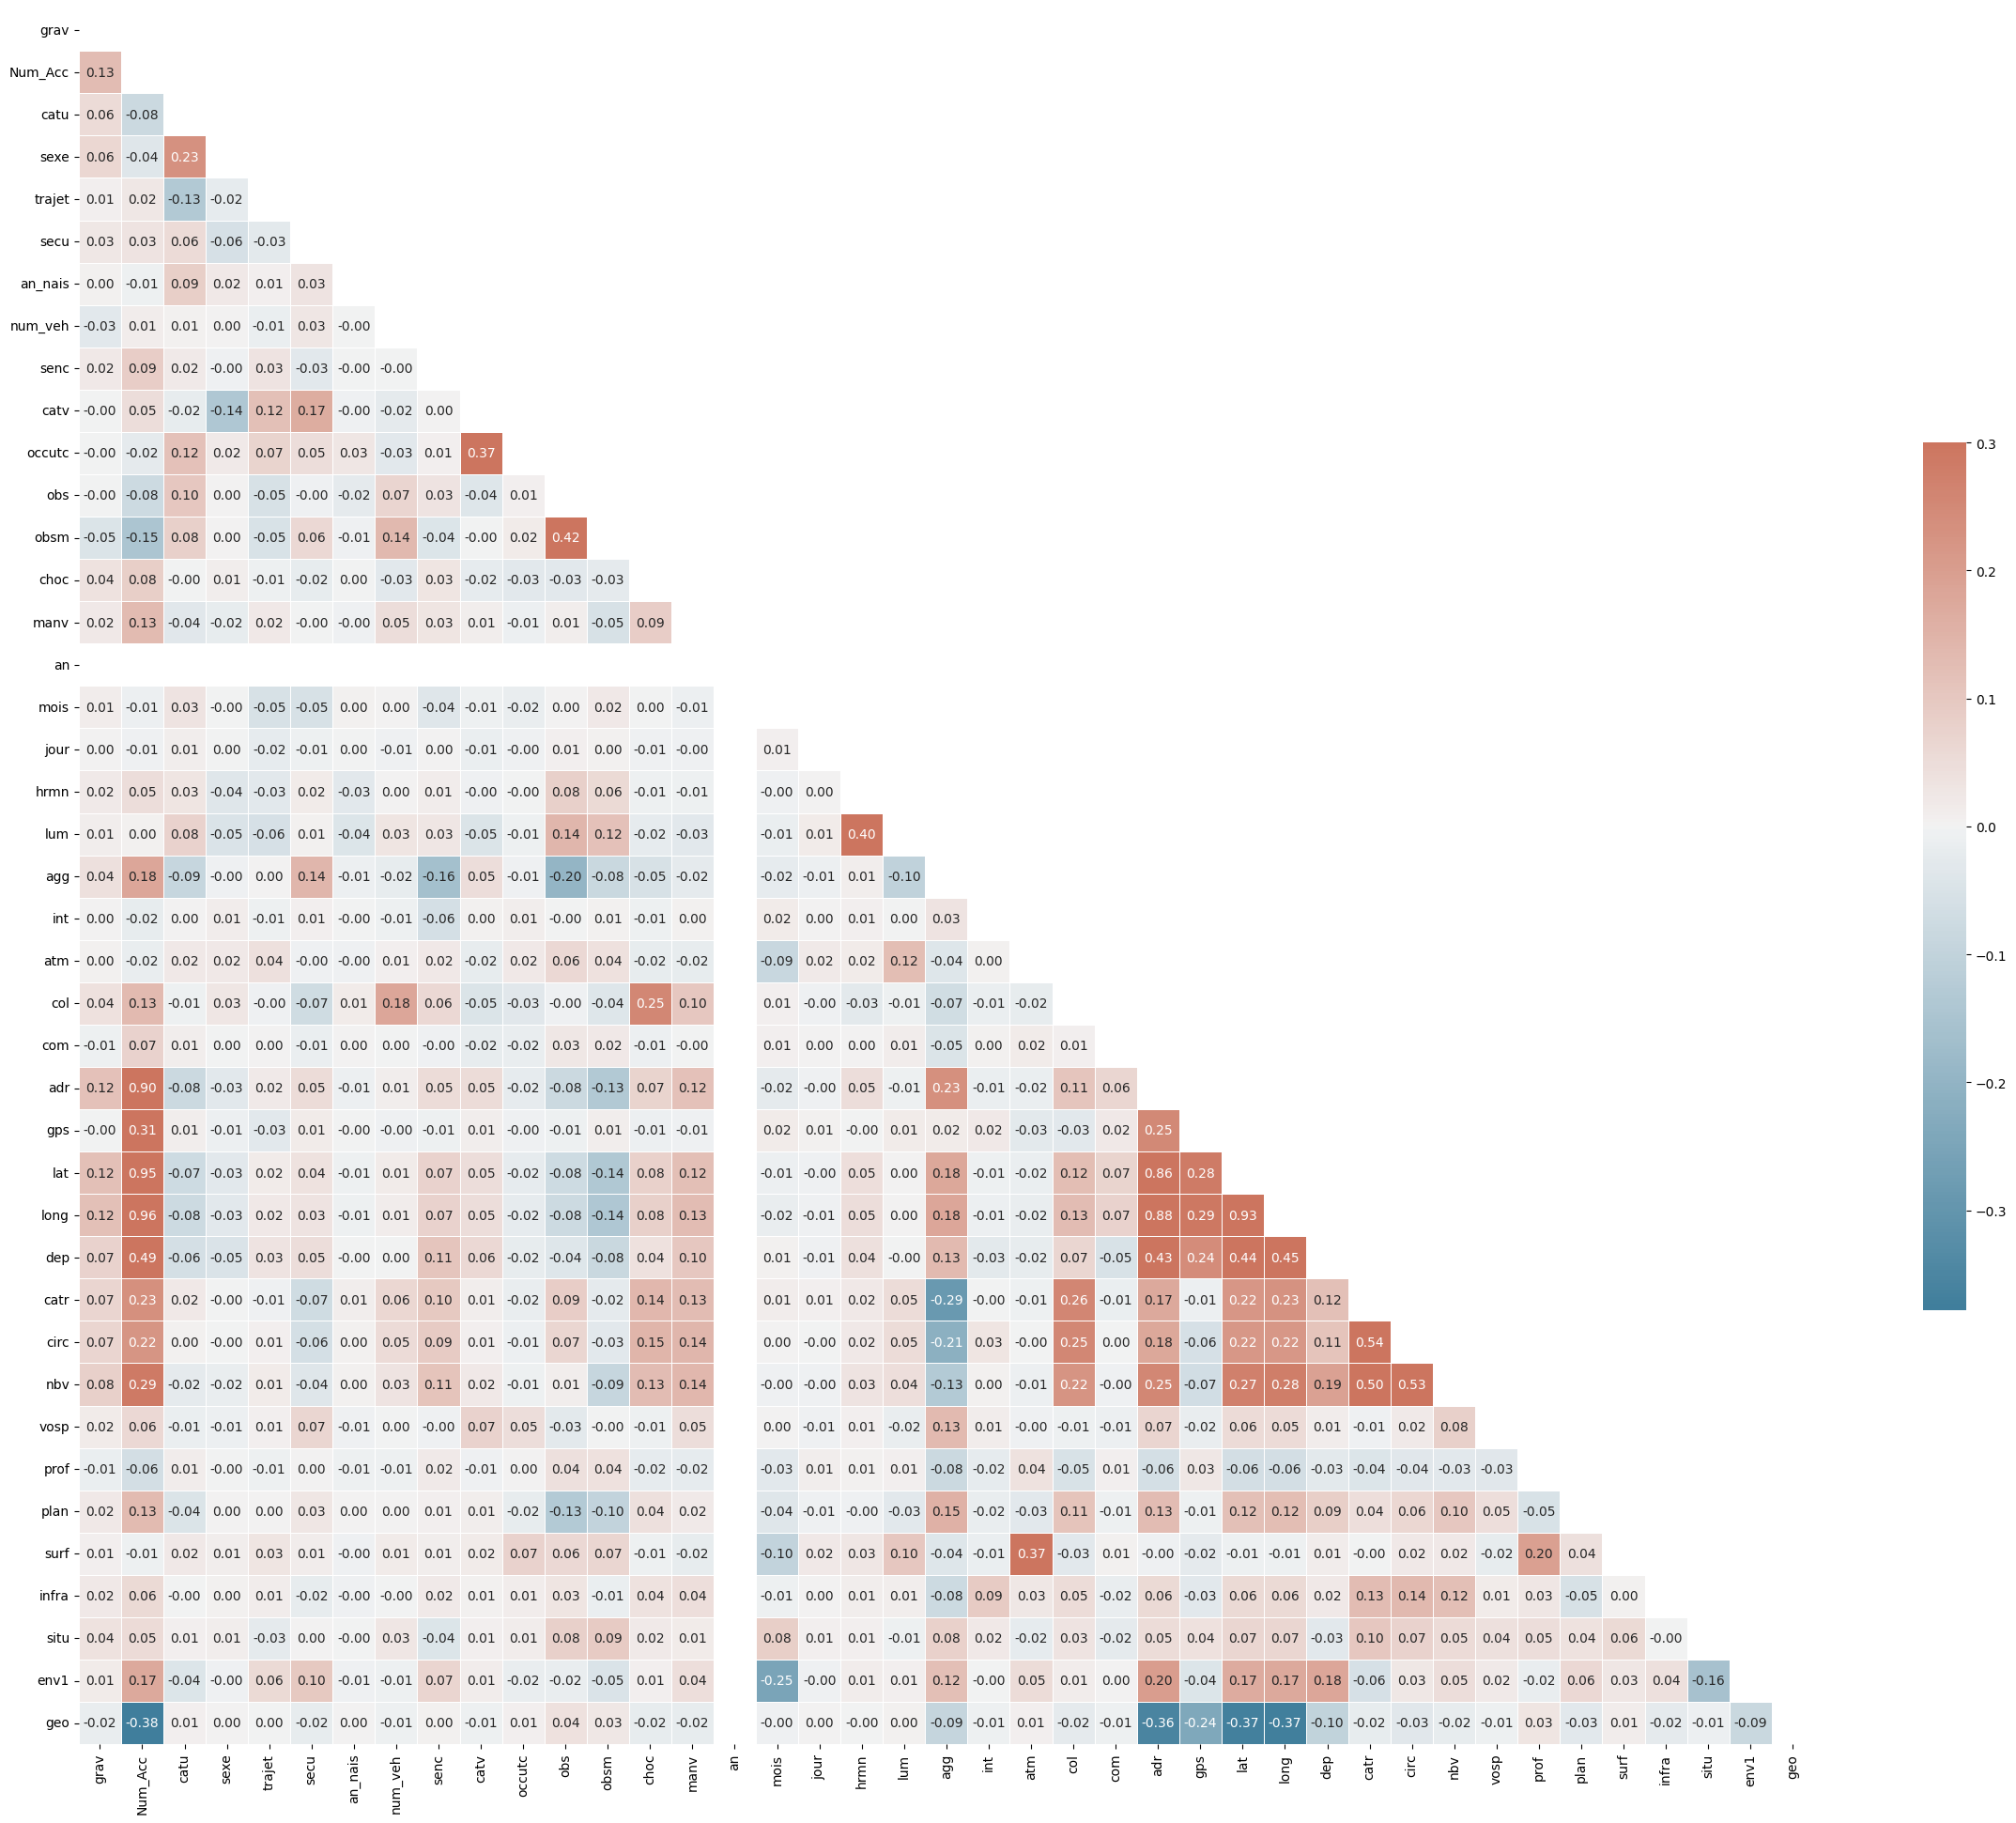

In [147]:
mask = np.triu(np.ones_like(data_reordered.apply(lambda x: x.factorize()[0]).corr(), dtype=bool))

# Set up the matplotlib figure with a larger size
f, ax = plt.subplots(figsize=(30, 24))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
heatmap_data = data_reordered.apply(lambda x: x.factorize()[0]).corr()
sns.heatmap(heatmap_data, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

plt.show()

Features's selection and encoding

In [148]:
Y = data['grav']

features = ['sexe','occutc','geo','catr','lum','obsm','surf','infra','catv','catu','trajet','secu','nbv']

X = pd.get_dummies(data[features].astype(str))

Split test/train

In [149]:
X = normalize(X.values)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state=42)

First Model with RandomForestClassifier

In [150]:
model_RandomForest = RandomForestClassifier(n_estimators=100, 
                                  max_depth=8
                                  )

model_RandomForest.fit(X_train, Y_train)
predictions_randomforest = model_RandomForest.predict(X_test)

Score_RandomForest = accuracy_score(Y_test, predictions_randomforest)
print(Score_RandomForest)

0.6070310825294748


Second Model with KNN

In [151]:
model_KNN = KNeighborsClassifier(n_neighbors=5)


model_KNN.fit(X_train, Y_train)
predictions_knn = model_KNN.predict(X_test)
Score_KNN = accuracy_score(Y_test, predictions_knn)
print(Score_KNN)


0.5844372990353698


Third Model with XGBoost

In [152]:
model_XGBoost = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss")

Y_train-=1
Y_test-=1

model_XGBoost.fit(X_train, Y_train)
predictions_xgboost = model_XGBoost.predict(X_test)
Score_xgboost = accuracy_score(Y_test, predictions_xgboost)
print(Score_xgboost)

0.6339549839228296
